# Descriptive stats for datasets and network localization

-------------------

Author: Brin Rosenthal (sbrosenthal@ucsd.edu)

-------------------

Notebook to calculate localization of dDNV sets, and measure number of patients with a dDNV in established disease genes, in a non-disease gene (non-recurrent), or no dDNVs.





<a id='import'></a>
## Import packages

In [1]:

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import pandas as pd
import random

from IPython.display import display

# latex rendering of text in graphs
import matplotlib as mpl
mpl.rc('text', usetex = False)
mpl.rc('font', family = 'serif')

from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']

sns.set_style('white')

sns.set_style("ticks", {"xtick.major.size": 15, "ytick.major.size": 15})
plt.rcParams['svg.fonttype'] = 'none'

import sys

% matplotlib inline

In [2]:
# need to have networkx version 1.11
nx.__version__

'1.11'

In [3]:
# import network localization methods

sys.path.append('netprop_zscore_code/')
import network_localization

[TOC](#toc)

<a id='importData'></a>
# Load the data- including ASD and CHD high confidence genes, and DNV sets



ASD genes come from table 4 in http://www.cell.com/neuron/fulltext/S0896-6273(15)00773-4 

In [4]:
# ------- ASD high confidence genes (established disease genes) -------

HC_genes_temp = pd.read_csv('data/HC_genes/ASD_HC.tsv',sep='\t',index_col='Unnamed: 0')
ASD_HC = [str(g[1:-1]).strip("'") for g in HC_genes_temp['seed_genes'].tolist()[0][1:-1].split(', ')]

len(ASD_HC)




65

In [5]:
# ------- High confidence CHD genes (established disease genes) -------

# Load congenital heart defect recurring DNVs (from https://www.nature.com/articles/ng.3970)

HC_genes_temp = pd.read_csv('data/HC_genes/CHD_HC.tsv',sep='\t',index_col='Unnamed: 0')
CHD_HC = [str(g[1:-1]).strip("'") for g in HC_genes_temp['seed_genes'].tolist()[0][1:-1].split(', ')]

len(CHD_HC)


66

In [7]:
# Load all NDD DNVs (from supp materials of CHD paper; from https://www.nature.com/articles/ng.3970)
NDD_df = pd.read_excel('data/SSC/homsy_database_S08.xlsx',skiprows=1)
ASD_DNV = NDD_df[NDD_df['Study']=='SSC'] # simons simplex data
print('\nnumber total ASD damaging DNVs')
print(len(ASD_DNV))
ASD_DNV_VC = ASD_DNV['Gene'].value_counts() # count recurrences
ASD_DNV = list(np.unique(ASD_DNV['Gene'].tolist()))
print('\nnumber unique ASD damaging DNVs:')
print(len(ASD_DNV))

print('\nnumber recurrent ASD damaging DNVs')
print(sum(ASD_DNV_VC>1)) # number recurrent ASD


number total ASD damaging DNVs
750

number unique ASD damaging DNVs:
663

number recurrent ASD damaging DNVs
63


In [8]:
# Load the new cohort (Supp table 9 from https://www.nature.com/articles/ng.3970)
CHD_new_df = pd.read_excel('data/CHD_databases_2017_paper/ng.3970-S3.xlsx',sheetname='S9',skiprows=1)
CHD_new_df.index=CHD_new_df['Blinded ID']

# apply the same filtering as for old data
CHD_new_df = CHD_new_df[(CHD_new_df['Variant_Class']!='syn')&(CHD_new_df['Variant_Class']!='mis')]

print('number total CHD damaging DNVs:')
print(len(CHD_new_df))

DNV_noNDD_full = CHD_new_df[CHD_new_df['NDD']=='No']
DNV_noNDD_full = DNV_noNDD_full['Gene'].unique().tolist()
print('\nnumber damaging CHD DNVs without NDD:')
print(len(DNV_noNDD_full))

DNV_withNDD_full = CHD_new_df[CHD_new_df['NDD']=='Yes']
DNV_withNDD_full = DNV_withNDD_full['Gene'].unique().tolist()
print('\nnumber damaging CHD DNVs with NDD:')
print(len(DNV_withNDD_full))

CHD_DNV = CHD_new_df['Gene'].unique().tolist()
CHD_DNV_VC = CHD_new_df['Gene'].value_counts()

print('\nnumber unique CHD damaging DNVs:')
print(len(CHD_DNV))


print('\nnumber recurrent CHD damaging DNVs ')
print(sum(CHD_DNV_VC>1)) # number recurrent CHD

/Users/brinrosenthal/anaconda3/envs/ipykernel_py2/lib/python2.7/site-packages/pandas/util/_decorators.py:188: FutureWarning: The `sheetname` keyword is deprecated, use `sheet_name` instead
  return func(*args, **kwargs)


number total CHD damaging DNVs:
827

number damaging CHD DNVs without NDD:
309

number damaging CHD DNVs with NDD:
198

number unique CHD damaging DNVs:
705

number recurrent CHD damaging DNVs 
66


In [9]:
# Load control DNVs (from Database S3)
ctrl_DNV_df = pd.read_excel('data/SSC/homsy_database_S03.xlsx',skiprows=1)

# exclude synonymouse and non-damaging missense
ctrl_DNV = ctrl_DNV_df[(ctrl_DNV_df['Variant Class']!='Synonymous')&(ctrl_DNV_df['Variant Class']!='Missense')]
ctrl_DNV_VC = ctrl_DNV['Gene'].value_counts()
print('number damaging control DNVs:')
print(len(ctrl_DNV))
#ctrl_DNV = ctrl_DNV_df
ctrl_DNV = list(np.unique(ctrl_DNV['Gene'].tolist()))
print('\nnumber unique damaging control DNVs:')
print(len(ctrl_DNV))

print('\nnumber recurrent damaging control DNVs:')
print(sum(ctrl_DNV_VC>1))


number damaging control DNVs:
201

number unique damaging control DNVs:
193

number recurrent damaging control DNVs:
7


## Define gene sets for use in rest of analysis

In [10]:
# pick out which gene sets to investigate
genes_ASD = ASD_HC
print(len(genes_ASD))
genes_CHD = CHD_HC
print(len(genes_CHD))

65
66


[TOC](#toc)

<a id='plotHCgenes'></a>
# Make figure 1: summary of HC genes in CHD and ASD  (showing low recurrence)



In [11]:
ASD_df = NDD_df[(NDD_df['Study']=='SSC')]
ASD_df.head()

,Study,CHR,POS,REF,ALT,Proband ID,Class,Class (2),Gene,Ensembl Gene ID,AA1,AA2,dbNSFP Meta-SVM Rankscore
1,SSC,1,1222518,C,A,11563.p1,nonsense,lof,SCNN1D,ENSG00000162572,NaN,NaN,NaN
3,SSC,1,3519049,AC,A,14075.p1,frameshift,lof,MEGF6,ENSG00000162591,NaN,NaN,NaN
4,SSC,1,11205057,T,C,11104.p1,missense,D-mis,MTOR,ENSG00000198793,M,V,0.83852
5,SSC,1,12175787,G,A,12340.p1,splice,lof,TNFRSF8,ENSG00000120949,NaN,NaN,NaN
6,SSC,1,12428630,T,C,13930.p1,missense,D-mis,VPS13D,ENSG00000048707,I,T,0.84048


In [12]:
CHD_DNV_df = CHD_new_df
CHD_DNV_df.head()

,Blinded ID,Cardiac Category,EM,NDD,CHROM,POS,REF,ALT,Ensemble_GENEID,Gene,Variant_Class,AA change,RadialSVM_score,RadialSVM_pred,ExAC_Overall,HHE Rank,pLI score
Blinded ID,,,,,,,,,,,,,,,,,
1-07417,1-07417,CTD,Yes,Unknown,5,132097207,C,G,ENSG00000164402,SEPT8,misD,p.R302P,0.657,D,.,86.369549,9.542857e-01
1-12717,1-12717,CTD,Yes,Yes,10,101578577,C,T,ENSG00000023839,ABCC2,misD,p.R768W,1.065,D,7.42e-05,16.124654,3.363414e-29
1-06692,1-06692,CTD,No,Unknown,17,48762187,C,T,ENSG00000108846,ABCC3,non,p.Q1411X,.,.,.,32.809230,2.616130e-14
1-06555,1-06555,other,No,No,1,94943860,A,G,ENSG00000117528,ABCD3,misD,p.I225V,1.123,D,3.34e-05,77.665290,9.996956e-01
1-07919,1-07919,LVO,Yes,No,4,146025629,G,A,ENSG00000164163,ABCE1,misD,p.R22Q,0.113,D,1.72e-05,82.195577,9.999826e-01


# Bar chart- how many DNVs within established disease genes compared to outside?

In [13]:
print(len(ASD_df))
display(ASD_df['Class (2)'].value_counts())
ASD_df.head()

750


lof      391
D-mis    359
Name: Class (2), dtype: int64

,Study,CHR,POS,REF,ALT,Proband ID,Class,Class (2),Gene,Ensembl Gene ID,AA1,AA2,dbNSFP Meta-SVM Rankscore
1,SSC,1,1222518,C,A,11563.p1,nonsense,lof,SCNN1D,ENSG00000162572,NaN,NaN,NaN
3,SSC,1,3519049,AC,A,14075.p1,frameshift,lof,MEGF6,ENSG00000162591,NaN,NaN,NaN
4,SSC,1,11205057,T,C,11104.p1,missense,D-mis,MTOR,ENSG00000198793,M,V,0.83852
5,SSC,1,12175787,G,A,12340.p1,splice,lof,TNFRSF8,ENSG00000120949,NaN,NaN,NaN
6,SSC,1,12428630,T,C,13930.p1,missense,D-mis,VPS13D,ENSG00000048707,I,T,0.84048


In [14]:
CHD_new_df.head()

,Blinded ID,Cardiac Category,EM,NDD,CHROM,POS,REF,ALT,Ensemble_GENEID,Gene,Variant_Class,AA change,RadialSVM_score,RadialSVM_pred,ExAC_Overall,HHE Rank,pLI score
Blinded ID,,,,,,,,,,,,,,,,,
1-07417,1-07417,CTD,Yes,Unknown,5,132097207,C,G,ENSG00000164402,SEPT8,misD,p.R302P,0.657,D,.,86.369549,9.542857e-01
1-12717,1-12717,CTD,Yes,Yes,10,101578577,C,T,ENSG00000023839,ABCC2,misD,p.R768W,1.065,D,7.42e-05,16.124654,3.363414e-29
1-06692,1-06692,CTD,No,Unknown,17,48762187,C,T,ENSG00000108846,ABCC3,non,p.Q1411X,.,.,.,32.809230,2.616130e-14
1-06555,1-06555,other,No,No,1,94943860,A,G,ENSG00000117528,ABCD3,misD,p.I225V,1.123,D,3.34e-05,77.665290,9.996956e-01
1-07919,1-07919,LVO,Yes,No,4,146025629,G,A,ENSG00000164163,ABCE1,misD,p.R22Q,0.113,D,1.72e-05,82.195577,9.999826e-01


In [15]:
# display(CHD_DNV_for_merge['Class'].value_counts())
# print(len(CHD_DNV_for_merge))
# display(CHD_DNV_for_merge['Gene'].value_counts().head())
# CHD_DNV_for_merge.head()

In [16]:
num_CHD_DNV_in_HC = sum(CHD_new_df['Gene'].isin(ASD_HC+CHD_HC))
print(num_CHD_DNV_in_HC)
num_CHD_DNV_not_HC = sum(~CHD_new_df['Gene'].isin(ASD_HC+CHD_HC))
print(num_CHD_DNV_not_HC)
num_CHD_no_DNV = 2645-(num_CHD_DNV_in_HC+num_CHD_DNV_not_HC)
print(num_CHD_no_DNV)

num_ASD_DNV_in_HC = sum(ASD_df['Gene'].isin(ASD_HC+CHD_HC))
print(num_ASD_DNV_in_HC)
num_ASD_DNV_not_HC = sum(~ASD_df['Gene'].isin(ASD_HC+CHD_HC))
print(num_ASD_DNV_not_HC)

num_ASD_no_DNV = 2759-(num_ASD_DNV_in_HC+num_ASD_DNV_not_HC)
print(num_ASD_no_DNV)

198
629
1818
120
630
2009


In [17]:
num_CHD_DNV_in_HC+num_CHD_DNV_not_HC

827

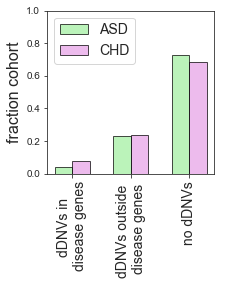

In [18]:
# add a bar showing the number of patients without damaging DNVs

sns.set_style('whitegrid',{'axes.grid':False})
sns.set_style("ticks", {"xtick.major.size": 15, "ytick.major.size": 15})
plt.rcParams['svg.fonttype'] = 'none'
plt.figure(figsize=(3,3))

plt.bar([-.15,.85,1.85],np.divide([num_ASD_DNV_in_HC,num_ASD_DNV_not_HC,num_ASD_no_DNV],2759.0),width=.3,
        color='#9FEE9D',alpha=.7,edgecolor='k',
       label='ASD')
plt.bar([.15,1.15,2.15],np.divide([num_CHD_DNV_in_HC,num_CHD_DNV_not_HC,num_CHD_no_DNV],2645.0),width=.3,
        color='#E69EE6',alpha=.7,edgecolor='k',
       label='CHD')


plt.ylim([0,1])
plt.xticks([0,1,2],['dDNVs in \ndisease genes', 'dDNVs outside \ndisease genes','no dDNVs'],fontsize=14,rotation='vertical')
plt.ylabel('fraction cohort',fontsize=16)
plt.legend(loc='upper left',fontsize=14)
# plt.savefig('../../manuscript/figures_1911/Figure1/Figure1_final assets/DNVs_in_out_disease_genes.png',dpi=300,bbox_inches='tight')
# plt.savefig('../../manuscript/figures_1911/Figure1/Figure1_final assets/DNVs_in_out_disease_genes.svg',dpi=300,bbox_inches='tight')

[TOC](#toc)

<a id='localization'></a>

# Select focal interactome, calculate network localization of DNVs

PCnet downloaded from ndex and parsed to networkx format 
https://ndexbio.org/#/network/f93f402c-86d4-11e7-a10d-0ac135e8bacf

In [19]:
# load the pre-computed interactome
# PCnet downloaded from ndex and parsed to networkx format 
# https://ndexbio.org/#/network/f93f402c-86d4-11e7-a10d-0ac135e8bacf
Gint = nx.read_gpickle('/Users/brinrosenthal/Documents/CCBB_tickets_data/PCnet/G_PCnet.gpickle')
int_name = 'PCnet'

In [20]:
print(len(Gint.nodes()))
print(len(Gint.edges()))

19781
2724724


### How much overlap is there between disease genes and selected interactome?




In [21]:
print(len(np.intersect1d(list(ASD_HC),Gint.nodes())))
print(len(ASD_HC))


print(len(np.intersect1d(list(CHD_HC),Gint.nodes())))
print(len(CHD_HC))

65
65
66
66


[TOC](#toc)

<a id='disease_localization'></a>

# How localized are the individual diseases?

Two localization methods implemented here:

1.  Largest connected component (following Menche et al)
2.  Number shared edges in gene set (similar to method on STRING-DB)


## ASD localization

In [22]:
# ----- distributions for non-sampled case -----
# set numreps to 5000 for full run
num_reps=100
ASD_numedges_list, ASD_numedges_rand, ASD_LCC_list, ASD_LCC_size_rand = network_localization.localization(Gint,
                                                                     focal_genes = ASD_DNV,
                                                                     num_reps = num_reps, 
                                                                     sample_frac = 1.0, 
                                                                     method = 'both', 
                                                                     plot = False,print_counter=True)

0
25
50
75


Text(0.5,1,'permutation p = 4.4e-129')

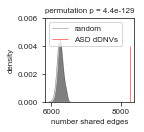

In [23]:
# plot distributions for non-sampled case
sns.set_style('white')
sns.set_style("ticks", {"xtick.major.size": 15, "ytick.major.size": 15})
plt.figure(figsize=(1.6,1.54))
plt.vlines(np.mean(ASD_numedges_list),ymin=0,ymax=0.004,color='r',lw=.5,label='ASD dDNVs')
sns.kdeplot(ASD_numedges_rand,color='k',lw=.5,alpha=.5,shade=True,label='random')
plt.legend(loc='upper left',fontsize=8)
plt.ylabel('density',fontsize=8)
plt.xlabel('number shared edges',fontsize=8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.ylim([0,.006])

# print the z-score and fdr
ASD_NE_z = (np.mean(ASD_numedges_list)-np.mean(ASD_numedges_rand))/np.std(ASD_numedges_rand)

from scipy.stats import norm
ptemp = norm.sf(abs(ASD_NE_z))

plt.title('permutation p = '+("%.2g" % ptemp),fontsize=8)

# plt.savefig('../../manuscript/figures_1911/Supplement/ASD_DNV_numedges_'+int_name+'_no_bootstrap'+str(num_reps)+'.png',dpi=300,bbox_inches='tight')
# plt.savefig('../../manuscript/figures_1911/Supplement/ASD_DNV_numedges_'+int_name+'_no_bootstrap'+str(num_reps)+'.svg',dpi=300,bbox_inches='tight')

## CHD localization

In [24]:
# ---- non-sampled case ----
# set numreps to 5000 for full run

num_reps=100
CHD_numedges_list, CHD_numedges_rand, CHD_LCC_list, CHD_LCC_size_rand = network_localization.localization(Gint,
                                                                     focal_genes = CHD_DNV,
                                                                     num_reps = num_reps, 
                                                                     sample_frac = 1.0, 
                                                                     method = 'both', 
                                                                     plot = False,print_counter=True)

0
25
50
75


Text(0.5,1,'permutation p = 8.1e-30')

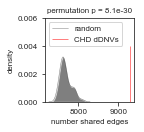

In [25]:
# plot distributions for non-sampled case
sns.set_style('white')
sns.set_style("ticks", {"xtick.major.size": 15, "ytick.major.size": 15})
plt.figure(figsize=(1.6,1.54))
plt.vlines(np.mean(CHD_numedges_list),ymin=0,ymax=0.004,color='r',lw=.5,label='CHD dDNVs')
sns.kdeplot(CHD_numedges_rand,color='k',lw=.5,alpha=.5,shade=True,label='random')
plt.legend(loc='upper left',fontsize=8)
plt.ylabel('density',fontsize=8)
plt.xlabel('number shared edges',fontsize=8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.ylim([0,.006])

# print the z-score and fdr
CHD_NE_z = (np.mean(CHD_numedges_list)-np.mean(CHD_numedges_rand))/np.std(CHD_numedges_rand)

from scipy.stats import norm
ptemp = norm.sf(abs(CHD_NE_z))

plt.title('permutation p = '+("%.2g" % ptemp),fontsize=8)

# plt.savefig('../../manuscript/figures_1911/Supplement/CHD_DNV_numedges_'+int_name+'_no_bootstrap'+str(num_reps)+'.png',dpi=300,bbox_inches='tight')
# plt.savefig('../../manuscript/figures_1911/Supplement/CHD_DNV_numedges_'+int_name+'_no_bootstrap'+str(num_reps)+'.svg',dpi=300,bbox_inches='tight')

## Control cohort localization

In [26]:
len(ctrl_DNV)

193

In [27]:
# set numreps to 5000 for full run

num_reps=100
CTRL_numedges_list, CTRL_numedges_rand, CTRL_LCC_list, CTRL_LCC_size_rand = network_localization.localization(Gint,
                                                                     focal_genes = ctrl_DNV,
                                                                     num_reps = num_reps, 
                                                                     sample_frac = 1.0, 
                                                                     method = 'both', 
                                                                     plot = False,print_counter=True)

0
25
50
75


Text(0.5,1,'permutation p = 0.23')

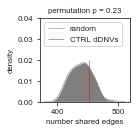

In [28]:
# plot distributions for non-sampled case
sns.set_style('white')
sns.set_style("ticks", {"xtick.major.size": 15, "ytick.major.size": 15})
plt.figure(figsize=(1.6,1.54))
plt.vlines(np.mean(CTRL_numedges_list),ymin=0,ymax=0.02,color='r',lw=.5,label='CTRL dDNVs')
sns.kdeplot(CTRL_numedges_rand,color='k',lw=.5,alpha=.5,shade=True,label='random')
plt.legend(loc='upper left',fontsize=8)
plt.ylabel('density',fontsize=8)
plt.xlabel('number shared edges',fontsize=8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.ylim([0,.04])

# print the z-score and fdr
CTRL_NE_z = (np.mean(CTRL_numedges_list)-np.mean(CTRL_numedges_rand))/np.std(CTRL_numedges_rand)

from scipy.stats import norm
ptemp = norm.sf(abs(CTRL_NE_z))

plt.title('permutation p = '+("%.2g" % ptemp),fontsize=8)

# plt.savefig('../../manuscript/figures_1911/Supplement/CTRL_DNV_numedges_'+int_name+'_no_bootstrap'+str(num_reps)+'.png',dpi=300,bbox_inches='tight')
# plt.savefig('../../manuscript/figures_1911/Supplement/CTRL_DNV_numedges_'+int_name+'_no_bootstrap'+str(num_reps)+'.svg',dpi=300,bbox_inches='tight')

[TOC](#toc)